In [214]:
#Guadalupe Maria Armenta Mendoza 
#R00259577

In [115]:
import numpy as np
import pandas as pd
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
from collections import Counter

In [216]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import load_model

## Pre-processing Phase:

In [3]:
#Pre-processing Phase:
#Functions to load the datasets
def load_images(path, target_size=(350, 350),  labeled=True):
    """
    Loads images and returns.
    -image_data: array of image data with shape (n_samples, height, width, 3). 3 =RGB
    -labels: array of labels (if labeled=False / if labeled=True).
    """
    image_data = []  #List to store image data
    labels = []  # List to store labels or image IDs
    path = Path(path)  #convert the path to a Path object to be easy to work with
    #If labeled, sort by filename to maintain order
    #If unlabeled, sort numericaly by the numeric part of the filename
    img_paths = sorted(
        path.glob('*.jpg'), #Retrieve all .jpg files in the directory
        key=lambda p: int(p.stem) if not labeled else p.name
    ) # 
    for img_path in img_paths:
        img = Image.open(img_path).convert('RGB').resize(target_size) #open the image & convert to RGB
        image_data.append(np.array(img))  #convert the image to a NumPy array and append to the list

        if labeled:
            #assign label based on the filename 
            if img_path.stem.startswith('cat'):
                labels.append(0)  #for cat
            elif img_path.stem.startswith('dog'):
                labels.append(1)  #for dog
            else:
                #skip files that don't match expeted naming convention
                continue
        else:
            #For unlabeled data, use the numeric part of the filename as the ID
            labels.append(int(img_path.stem))

    print(f"> Loaded {len(image_data)} {'labeled' if labeled else 'unlabeled'} images from {path}")
    return np.stack(image_data), np.array(labels)

In [11]:
a_train, b_train = load_images('data/train') #Load training data with labels inferred from filenames
a_test, b_test = load_images('data/test') #Load test data without labels; filenames are used as IDs
#Let's see a_train is shape (data amount, Height, Width, Filter)
print("a_train shape:", a_train.shape) #let' see the shapes
print("b_test shape:", a_test.shape) 

> Loaded 1002 labeled images from data\train
> Loaded 100 labeled images from data\test
a_train shape: (1002, 350, 350, 3)
b_test shape: (100, 350, 350, 3)


In [13]:
#Now let's normalize the data
#Converts to flot & scales pixel range to [0, 1] - This needed for most ML models
a_train = a_train.astype('float32') / 255.0
a_test  = a_test.astype('float32')  / 255.0

In [15]:
#let see if we have a balanced class distribuitions
print("Class distribution:", Counter(b_train))

Class distribution: Counter({0: 501, 1: 501})


In [17]:
#PCA 
#First we need to flatten for PCA
n, H, W, C = a_train.shape
train_flat = a_train.reshape(n, H * W * C)
test_flat  = a_test.reshape(a_test.shape[0], H * W * C)

#Now we can fit PCA on the  flattened images
pca_full = PCA().fit(train_flat)  
explained_var = pca_full.explained_variance_ratio_ #compute explained‐variance ratios
cummulative= np.cumsum(pca_full.explained_variance_ratio_) #see cumulative variance

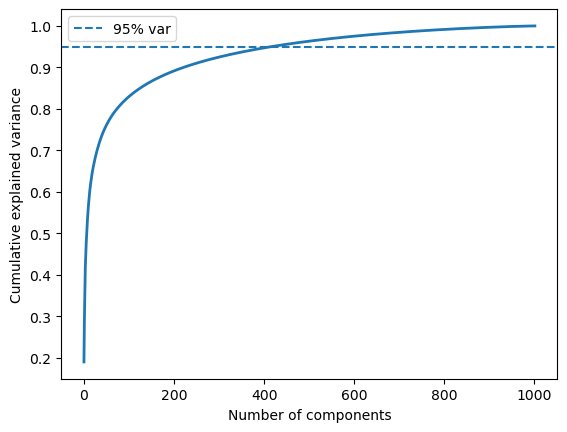

In [19]:
#Plot the cumulative explained variance 
plt.plot(cummulative, lw=2)
plt.axhline(0.95, linestyle='--', label='95% var')
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.legend()
plt.show()

In [35]:
#Now's let's transform the train and test sets 
K = 0.95 #Threshold for variances 
pca = PCA(n_components=K)
train_pca = pca.fit_transform(train_flat) #applied to the train data
test_pca  = pca.transform(test_flat) #applied to the test data
print("Dimensions after PCA:", train_pca.shape, test_pca.shape) #To see if PCA is worthy to apply in the dataset

Dimmesions after PCA: (1002, 417) (100, 417)


#### We ended up with just 417 components to capture 95 % of the variance instead of the original 350 × 350 × 3 =367 500 features, almost 900 reduction in dimensinality. In this case , PCA is super worthwhile here, since we compress down to a few hundred features with minimal information loss.

## Training phase: 

#### First, we will  establish a baseline using a simple random forest (simple ML model). Then, we gonna build a convolutional neural network (CNN) from scratch using Conv2D and another layer available in Keras. Finally,  pre-trained VGG16 model to see if we can achieve better performance with minimal training

### *Random Forest*  -> Baseline Model

In [53]:
#Split the PCA transformed data into training and validation sets
RF_tr, RF_val, rf_tr, rf_val = train_test_split(train_pca, b_train, test_size=0.2, random_state=42)
#initialize the Random Forest classifier
random_forest = RandomForestClassifier(n_estimators=100, random_state=42) #number of trees & random seed
#train the model on the PCA-reduced training data
random_forest.fit(RF_tr, rf_tr)
#Let's evaluate the model
predictor = random_forest.predict(RF_val) #predict on the validation set
##Printing the accuracy
accuracy = accuracy_score(rf_val, predictor)
print(f"Random Forest Accuracy (95% PCA): {accuracy * 100:.2f}%")

Random Forest Accuracy (95% PCA): 59.20%


In [57]:
#Because the accuracy with PCA was quite low, we decided to try without the PCA transformation
flat_raw = a_train.reshape(a_train.shape[0], -1)  #each image becomes a 1D array
#Split the flattened data into training and validation sets
RF_tr, RF_val, rf_tr, rf_val= train_test_split(flat_raw, b_train, test_size=0.2, random_state=42)

#Initialize the RF classifier
rf_raw = RandomForestClassifier(n_estimators=100, random_state=42) #number of trees & random seed
rf_raw.fit(RF_tr, rf_tr) #train the model on the row pixel data

#Let's evaluate the model again
predictor = rf_raw.predict(RF_val) #predict on the validation set
#Printing the accuracy 
accuracy_raw = accuracy_score(rf_val, predictor) * 100
print(f"Random Forest Accuracy on Raw data (No PCA): {accuracy_raw:.2f}%")

Random Forest Accuracy on Raw data (No PCA): 62.69%


#### Results summary  
- Random Forest Accuracy (95% PCA): 59.20
- Random Forest Accuracy on Raw data (No PCA): 62.69

### *Conv2D* -> based on the book Deep learning with Python, 2nd edition   (Francois Chollet, 2021)

In [63]:
#Downsampling to fi the data into the network, reload images with lower resolution for CNN only
cnn_train, cnn_labels = load_images('data/train', target_size=(128, 128)) #because my laptop capacity

> Loaded 1002 labeled images from data\train


In [73]:
#splitting the data
Conv2D_train, Conv2D_val, Conv_train, Conv_val = train_test_split(cnn_train, cnn_labels, test_size=0.2, random_state=42)
#Preparing the CNN model
model = Sequential([ #1st conv block
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    layers.MaxPooling2D((2, 2)),
    #2nd conv block
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    #Fully connected layers
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),  #to prevent overfitting
    layers.Dense(1, activation='sigmoid')  #binary classification output
])
#Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [75]:
#train the CNN model
history = model.fit(
    Conv2D_train, Conv_train,
    epochs=10,
    batch_size=16,  #smaller batch to reduce memory usage
    validation_data=(Conv2D_val, Conv_val))

Epoch 1/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 11s 144ms/step - accuracy: 0.4816 - loss: 117.0695 - val_accuracy: 0.5025 - val_loss: 0.6882
Epoch 2/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 7s 140ms/step - accuracy: 0.5963 - loss: 0.6489 - val_accuracy: 0.5771 - val_loss: 0.6918
Epoch 3/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 7s 132ms/step - accuracy: 0.7209 - loss: 0.5133 - val_accuracy: 0.5473 - val_loss: 0.7196
Epoch 4/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 7s 133ms/step - accuracy: 0.8587 - loss: 0.3722 - val_accuracy: 0.6070 - val_loss: 0.7616
Epoch 5/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.8534 - loss: 0.3056 - val_accuracy: 0.6368 - val_loss: 1.0135
Epoch 6/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 6s 124ms/step - accuracy: 0.9209 - loss: 0.2705 - val_accuracy: 0.5771 - val_loss: 1.0810
Epoch 7/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 0.9350 - loss: 0.2271 - val_accuracy: 0.5970 - val_loss: 1.5531
Epoch 8/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 7s 132ms/step - accuracy: 0.9306 - loss: 0.1688 - val_accuracy:

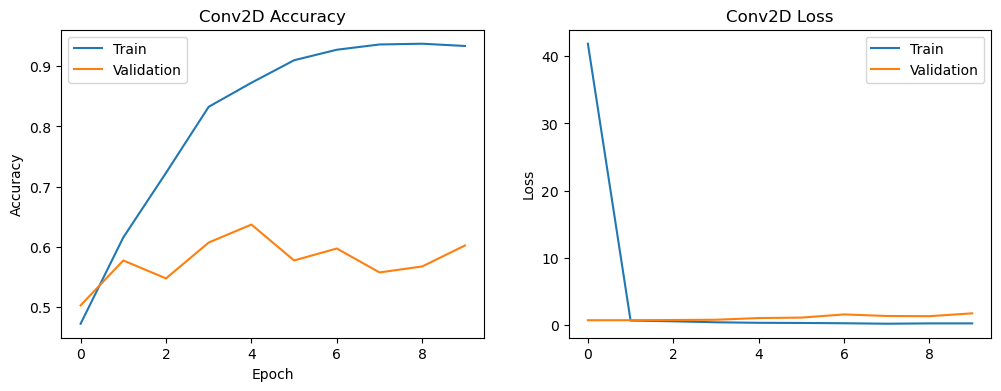

In [77]:
#Plotting the Accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Conv2D Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

#Plotting the Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Conv2D Loss')
plt.ylabel('Loss')
plt.legend()
plt.show()

Overall, we assume our model has too much capacity relative to the size and diversity of the training set (only less than 800 images after split). Without augmentation or regularization, it memorizes training data instead of learning general patterns.
We understand that this is expected when training the model initially, so we will focus on tuning some parameters later to improve the generalizability of the model.

### *VGG16* -> Based on the Machine Learning Mastery blog (Jason Brownlee, 2021)

In [139]:
import shutil
#In order to fit this module, we should createa new folder structure
Path("data/train/cats").mkdir(parents=True, exist_ok=True)
Path("data/train/dogs").mkdir(parents=True, exist_ok=True)

#We nee d to move the images into class folders based on class (cat , dog)
for img_path in Path("data/train").glob("*.jpg"):
    if img_path.stem.startswith("cat"):
        shutil.move(str(img_path), "data/train/cats/")
    elif img_path.stem.startswith("dog"):
        shutil.move(str(img_path), "data/train/dogs/")

In [141]:
#Prepare the data to use the VGG16
#As a first step, we're gonna generate a data generator as a preprocessing step to VGG16, because my laptop can't handle too much size 
dataGen = ImageDataGenerator(
    preprocessing_function=preprocess_input,  #normalizes input for VGG16
    validation_split=0.2) #split 80/20 validation

#loading training subset from folder (uses filenames to label classes)
train_gen = dataGen.flow_from_directory('data/train',              #indicate the directory where the data train ins located
    target_size=(224, 224),    #because VGG16 takes only 224x224 images
    batch_size=16, 
    class_mode='binary',       #binary outcome
    subset='training',
    shuffle=True)#randomize the training input 

#validation subset
val_gen = dataGen.flow_from_directory('data/train', target_size=(224, 224), batch_size=16, class_mode='binary', subset='validation',
shuffle=False)

Found 802 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


In [143]:
#So, now let's build the VGG16-based model
#Load the VGG16 model without the top classification layers
base_model = VGG16(
    weights='imagenet',        #using weights pre-trained on ImageNet
    include_top=False,         #excluding the top classification layers
    input_shape=(224, 224, 3))  #input shape matches the preprocessed images

base_model.trainable = False #freeze its weights from being updated during training

# Create a new model on top
model = models.Sequential([base_model,
    layers.Flatten(),                      #Flatting the output of the base model
    layers.Dense(256, activation='relu'),  #Adding a fully connected layer
    layers.Dropout(0.5),                   #Adding dropout for regularization
    layers.Dense(1, activation='sigmoid')  #reshaping the layar for binary classification
])

In [169]:
#Finally let's define and compile the model
#looad the VGG16 base model with pretrained imageNet weights
base_model = VGG16(
    weights='imagenet',
    include_top=False, #remove the fully connected layers at the top
    input_shape=(224, 224, 3))

#freeze the base model layers so they don't get updated during training, avoiding overfitting
base_model.trainable = False

#Builting a new model on top of VGG16
model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),                   #to reduce overfooting
    layers.Dense(1, activation='sigmoid')])  # Output layer for binary classification
#compiling the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [147]:
#Train the Model
history = model.fit(train_gen, epochs=10, validation_data=val_gen) #only 10 epochs as it takes sometime to run ---

C:\Users\lupit\ML-anaconda\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 211s 4s/step - accuracy: 0.8464 - loss: 8.5432 - val_accuracy: 0.9750 - val_loss: 1.6509
Epoch 2/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 241s 5s/step - accuracy: 0.9847 - loss: 1.0523 - val_accuracy: 0.9850 - val_loss: 0.7374
Epoch 3/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 266s 5s/step - accuracy: 0.9920 - loss: 0.3414 - val_accuracy: 0.9650 - val_loss: 1.2551
Epoch 4/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 170s 3s/step - accuracy: 0.9932 - loss: 0.3930 - val_accuracy: 0.9750 - val_loss: 0.9703
Epoch 5/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 163s 3s/step - accuracy: 0.9801 - loss: 0.8448 - val_accuracy: 0.9750 - val_loss: 2.5304
Epoch 6/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 155s 3s/step - accuracy: 0.9859 - loss: 1.4329 - val_accuracy: 0.9700 - val_loss: 1.7816
Epoch 7/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 152s 3s/step - accuracy: 0.9897 - loss: 0.5509 - val_accuracy: 0.9750 - val_loss: 1.0704
Epoch 8/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 151s 3s/step - accuracy: 0.9990 - loss: 0.1096 - val_accuracy: 0.9850 - v

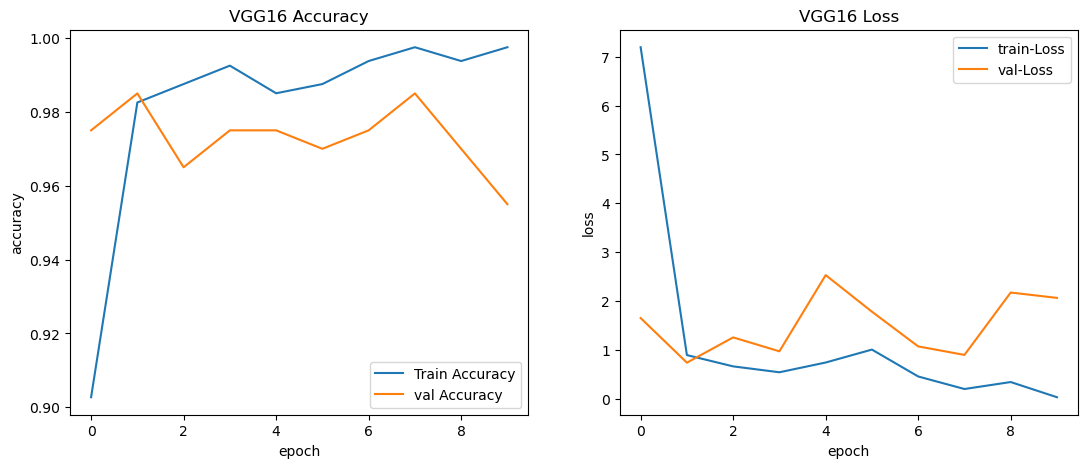

In [151]:
#Visualize Training Performance
#plotting the accuracy
plt.figure(figsize=(13, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='val Accuracy')
plt.title('VGG16 Accuracy')
plt.xlabel('epoch')
plt.legend()
plt.ylabel('accuracy')

#Plotting the loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='train-Loss')
plt.plot(history.history['val_loss'], label='val-Loss')
plt.title('VGG16 Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

#So far, VGG16 Transfer Learning: achieved 98% validation accuracy out of the box, with minimal tuning.... the only drawback of this models is that takes longer to convolute in my laptop, around 15 min

### Models trained ###
| Model                               | Features Used            | Validation Accuracy (%) | Notes                         |
| ----------------------------------- | ------------------------ | ----------------------- | ----------------------------- |
| **Random Forest + PCA (95%)**       | PCA-transformed features | **59.20%**              | Weak baseline                     |
| **Random Forest (raw)**             | Raw flattened images     | **63%**              | Best classical ML model     |
| **Custom CNN**                      | 128×128 RGB images       | **61%**            | Not bad results , but there is  overfitting |
| **VGG16 (Transfer Learning)**       | 224×224 RGB + ImageNet   | **96%**              | Best model, so far       |


###  Optimization phase:  
1. Conv2D
2. VGG16 (Transfer)

In [165]:
#1. Conv2D
#Data Augmentation Setup#
# Augmented training generator
augment_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,        # ±10° rotation
    zoom_range=0.2,           # ±20% zoom
    horizontal_flip=True,     # 50% chance
    validation_split=0.2
)
#Clean validation generator
# 2) Training generator (80% of data)
train_gen_conv = augment_gen.flow_from_directory(
    'data/train',
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    subset='training')      # <-- uses that 80%

# 3) Validation generator (20% of data)
val_gen_conv = augment_gen.flow_from_directory(
    'data/train',
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    subset='validation')     # <-- uses the reserved 20%


Found 802 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


In [173]:
#Conv2d architecture
model = models.Sequential([ layers.Input(shape=(128, 128, 3)),
    #1st Block
    layers.Conv2D(32, (3, 3), activation='relu'), 
    layers.MaxPooling2D(pool_size=2),
    layers.Dropout(0.2),
     #2nd Block
    layers.Conv2D(64, (3, 3),  activation='relu'),
    layers.MaxPooling2D(pool_size=2),
    layers.Dropout(0.3),   
     #3rd Block
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=2),
    layers.Dropout(0.4),
    
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.Dropout(0.5),
     ## Fully Connected Head
    layers.Flatten(),
    layers.Dense(1, activation='sigmoid')
])

#Compiling the model
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']) 

callbacks = ModelCheckpoint('best_cnn_model.keras', monitor='val_loss', save_best_only=True)

In [177]:
#Train
history = model.fit(
    train_gen,
    epochs=50,         #increment the number of epochs
    validation_data=val_gen,
callbacks=callbacks)

Epoch 1/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 21s 789ms/step - accuracy: 0.4962 - loss: 0.6941 - val_accuracy: 0.5600 - val_loss: 0.6923
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 40s 756ms/step - accuracy: 0.5372 - loss: 0.6866 - val_accuracy: 0.5450 - val_loss: 0.6894
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 19s 719ms/step - accuracy: 0.5712 - loss: 0.6910 - val_accuracy: 0.5200 - val_loss: 0.6929
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 19s 715ms/step - accuracy: 0.5751 - loss: 0.6797 - val_accuracy: 0.6250 - val_loss: 0.6697
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 19s 734ms/step - accuracy: 0.6473 - loss: 0.6315 - val_accuracy: 0.5300 - val_loss: 0.7007
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 20s 756ms/step - accuracy: 0.5663 - loss: 0.6851 - val_accuracy: 0.6050 - val_loss: 0.6485
Epoch 7/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 19s 719ms/step - accuracy: 0.6417 - loss: 0.6315 - val_accuracy: 0.5950 - val_loss: 0.6301
Epoch 8/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 18s 683ms/step - accuracy: 0.6661 - loss: 0.6289 - val_accu

In [204]:
# Final epoch metrics
final_val_loss     = history.history['val_loss'][-1]
final_val_accuracy = history.history['val_accuracy'][-1]
print(f"Final Validation  — Loss: {final_val_loss:.4f}, Accuracy: {final_val_accuracy:.4f}")

Final Validation  — Loss: 0.6597, Accuracy: 0.6900


*So, 70%  is the validation performance at the very last epoch of training. It’s often used as a general benchmark, but it may not represent the best-performing model due to overfitting*

In [182]:
#Check the best metrics saved 
model.load_weights('best_cnn_model.keras')
model.evaluate(val_gen)

7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 422ms/step - accuracy: 0.6838 - loss: 0.5477


[0.546144962310791, 0.7200000286102295]

1. Loss: 0.5461 The binary cross-entropy on the validation set.
2. Accuracy: 72% meaning the  model correctly classified around 72% of validation images.

#### For the VGG16 we will add the following parameters:
* Build a new head (classifier)
* Train only the top layers first (warm-up phase)
* Unfreeze some VGG16 layers

In [193]:
# Because we're gonna add Data Generators - wee need to reshape the iput size
augment_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2)
# Training generator for VGG16 (224×224 inputs)
train_gen = augment_gen.flow_from_directory(
    'data/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='training',
    shuffle=True)

# Validation generator (same augment_gen with split)
val_gen = augment_gen.flow_from_directory(
    'data/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation',
    shuffle=False)

Found 802 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


In [195]:
#Now, we gonna build a new classifier on top of the VGG16, adding more layers and drop out 
conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
conv_base.trainable = False  #Freeze entire base

model = models.Sequential([
    conv_base,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')])

#compiling the model
model.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(learning_rate=1e-4), #now ge gonna try a new optimizer
    metrics=['accuracy'])

In [197]:
#Initial Training (Part 1)
callbacks_stage1 = [
    EarlyStopping(patience=3, restore_best_weights=True),
    ModelCheckpoint('VGG16_finetuned_stage1.keras', save_best_only=True)]

history_stage1 = model.fit(
    train_gen,
    epochs=10,
    validation_data=val_gen,
    callbacks=callbacks_stage1)

C:\Users\lupit\ML-anaconda\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 163s 6s/step - accuracy: 0.5908 - loss: 0.8405 - val_accuracy: 0.8550 - val_loss: 0.3781
Epoch 2/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 157s 6s/step - accuracy: 0.7670 - loss: 0.4623 - val_accuracy: 0.8600 - val_loss: 0.3314
Epoch 3/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 160s 6s/step - accuracy: 0.8013 - loss: 0.4219 - val_accuracy: 0.9200 - val_loss: 0.2793
Epoch 4/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 193s 8s/step - accuracy: 0.8656 - loss: 0.2951 - val_accuracy: 0.9050 - val_loss: 0.2493
Epoch 5/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 156s 6s/step - accuracy: 0.8675 - loss: 0.3093 - val_accuracy: 0.8500 - val_loss: 0.3096
Epoch 6/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 181s 7s/step - accuracy: 0.8853 - loss: 0.2583 - val_accuracy: 0.9050 - val_loss: 0.2382
Epoch 7/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 239s 9s/step - accuracy: 0.8836 - loss: 0.2562 - val_accuracy: 0.8000 - val_loss: 0.4229
Epoch 8/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 240s 9s/step - accuracy: 0.8741 - loss: 0.3124 - val_accuracy: 0.9100 - v

In [199]:
##unfreeze & Fine-Tune (Phase 2)
conv_base.trainable = True
for layer in conv_base.layers:
    # only unfreeze the last convolutional block
    layer.trainable = layer.name.startswith('block5_')

model.compile(loss='binary_crossentropy',optimizer=RMSprop(learning_rate=1e-5)metrics=['accuracy'])

callbacks_stage2 = [EarlyStopping(patience=3, restore_best_weights=True),ModelCheckpoint('VGG16_finetuned_stage2.keras', save_best_only=True)]

history_stage2 = model.fit(train_gen, epochs=10, validation_data=val_gen, callbacks=callbacks_stage2)

Epoch 1/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 251s 9s/step - accuracy: 0.9376 - loss: 0.1617 - val_accuracy: 0.9200 - val_loss: 0.1902
Epoch 2/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 234s 9s/step - accuracy: 0.9514 - loss: 0.1569 - val_accuracy: 0.9300 - val_loss: 0.1780
Epoch 3/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 264s 10s/step - accuracy: 0.9647 - loss: 0.1113 - val_accuracy: 0.9150 - val_loss: 0.1995
Epoch 4/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 13245s 529s/step - accuracy: 0.9631 - loss: 0.0931 - val_accuracy: 0.9350 - val_loss: 0.2413
Epoch 5/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 194s 7s/step - accuracy: 0.9682 - loss: 0.0878 - val_accuracy: 0.9100 - val_loss: 0.1760
Epoch 6/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 165s 6s/step - accuracy: 0.9769 - loss: 0.0651 - val_accuracy: 0.9300 - val_loss: 0.1866
Epoch 7/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 171s 7s/step - accuracy: 0.9753 - loss: 0.0647 - val_accuracy: 0.9450 - val_loss: 0.1653
Epoch 8/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 192s 7s/step - accuracy: 0.9795 - loss: 0.0561 - val_accuracy: 0.940

In [202]:
#Final epoch metrics from the fine-tuning run
final_val_acc = history_stage2.history['val_accuracy'][-1]
final_val_loss = history_stage2.history['val_loss'][-1]
print(f"Stage 2 Fine-tuning → Last Epoch  — Loss: {final_val_loss:.4f}, Accuracy: {final_val_acc:.4f}")

#Bess Metrics, according to the validation loss
best_epoch = int(np.argmin(history_stage2.history['val_loss']))
best_val_acc  = history_stage2.history['val_accuracy'][best_epoch]
best_val_loss = history_stage2.history['val_loss'][best_epoch]
print(f"Stage 2 Fine-tuning → Best Epoch #{best_epoch+1}  — Loss: {best_val_loss:.4f}, Accuracy: {best_val_acc:.4f}")

Stage 2 Fine-tuning → Last Epoch  — Loss: 0.1646, Accuracy: 0.9450
Stage 2 Fine-tuning → Best Epoch #8  — Loss: 0.1644, Accuracy: 0.9400


The small drop from 93.00% (in the history object) to 92.81% (from model.evaluate) is  normal, it can come from differences in how Keras batches and rounds metrics during training versus a final clean evaluation as per the book DL with python.

### Optimization Phase Summary ###
So far we have trained and optimice the following modols 
1. A strong classical ML baseline (RF raw: 62.7%)
2. Robust Conv2D (72.5%)
3. Frozen-base VGG16:  Val Loss: 0.1905, Val Accuracy: 0.9250  
4. Fine-tuned VGG16: Val Loss: 0.1416, Val Accuracy: 0.9350  
